# Crack detection in concrete

In [1]:
!pip install opencv-python

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [28]:
!pip install split-folders

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Importing necessary libraries

In [29]:
import pandas as pd
import os
import random
import cv2
from matplotlib import pyplot as plt
import splitfolders

## Loading the dataset

In [30]:
positive_dataset_path = './Concrete Crack Images for Classification/Positive/'
negative_dataset_path = './Concrete Crack Images for Classification/Negative/'
dataset_path = "Concrete Crack Images for Classification"

In [22]:
pos_images = os.listdir(positive_dataset_path)
neg_images = os.listdir(negative_dataset_path)

Number of images with cracks: 20000
Number of images without crack: 20000
Image with a crack


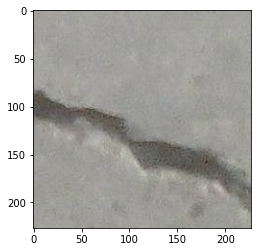

Image without a crack


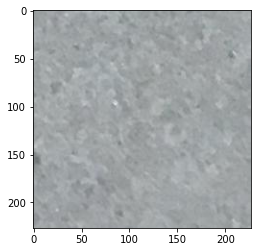

In [23]:
print('Number of images with cracks:', len(pos_images))
print('Number of images without crack:', len(neg_images))
pos_path = pos_images[random.randint(0,len(pos_images))]
rand_pos_img = cv2.imread(f'{positive_dataset_path}{pos_path}')
neg_path = neg_images[random.randint(0,len(neg_images))]
rand_neg_img = cv2.imread(f'{negative_dataset_path}{neg_path}')
print("Image with a crack")
plt.imshow(rand_pos_img)
plt.show()
print("Image without a crack")
plt.imshow(rand_neg_img)
plt.show()

### Divide into train, test and validation

In [24]:
root_dir = 'Images'
pos_dir = 'Positive'
neg_dir = 'Negative'

In [31]:
splitfolders.ratio(input=dataset_path, output=root_dir, seed=1337, ratio=(.7, .15, .15), group_prefix=None )


In [32]:
train_pos = os.listdir(f'{root_dir}/train/{pos_dir}')
train_neg = os.listdir(f'{root_dir}/train/{neg_dir}')
val_pos = os.listdir(f'{root_dir}/val/{pos_dir}')
val_neg = os.listdir(f'{root_dir}/val/{neg_dir}')
test_pos = os.listdir(f'{root_dir}/test/{pos_dir}')
test_neg = os.listdir(f'{root_dir}/test/{neg_dir}')


In [33]:
print("Number of train positive: ", len(train_pos))
print("Number of train neg: ", len(train_neg))
print("Number of val positive: ", len(val_pos))
print("Number of val neg: ", len(val_neg))
print("Number of test positive: ", len(test_pos))
print("Number of test neg: ", len(test_neg))


Number of train positive:  14000
Number of train neg:  14000
Number of val positive:  3000
Number of val neg:  3000
Number of test positive:  3000
Number of test neg:  3000


0.7